### 0. Directory setting

In [1]:
import os
import sys

# Get current notebook directory
notebook_dir = os.getcwd()

# Navigate to project root if notebook is in 'notebooks' folder
project_dir = notebook_dir
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
    os.chdir(project_dir)

# Add project root to sys.path if not already included
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

### 1. Imports and Setup

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import logging

# Import custom modules
import sys
sys.path.append('./')
from utils.data_loader import load_data, load_anomaly_labels, normalize_data, create_sequences
from utils.data_loader import create_prediction_sequences
from utils.model_utils import LSTMPredictor, train_model

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Usando dispositivo: {device}")


2025-05-23 21:39:21,888 - INFO - Usando dispositivo: cpu


### 2. Data Loading and Preprocessing

In [3]:

# Load data
filepath = 'data/machine_temperature_system_failure.csv'
df = load_data(filepath)

data_scaled, scaler = normalize_data(df[['value']])

# Create sequences for prediction
sequence_length = 150
prediction_horizon = 24  # Predict 24 steps ahead

X, y = create_prediction_sequences(data_scaled, seq_length=sequence_length, horizon=prediction_horizon)

# Split data
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


2025-05-23 21:39:21,901 - INFO - Charging data from data/machine_temperature_system_failure.csv
2025-05-23 21:39:21,923 - INFO - Charged data: 22695 registers


### 3. Model Definitions

In [4]:

# Define model classes
class LSTMMultiStepPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMMultiStepPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        # Reshape to [batch_size, prediction_horizon, 1]
        return out.view(batch_size, -1, 1)

class GRUMultiStepPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRUMultiStepPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        # Reshape to [batch_size, prediction_horizon, 1]
        return out.view(batch_size, -1, 1)

class TransformerPredictor(nn.Module):
    def __init__(self, input_size, d_model, nhead, dim_feedforward, num_layers, output_size, dropout=0.2):
        super(TransformerPredictor, self).__init__()
        self.d_model = d_model
        
        self.input_projection = nn.Linear(input_size, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_projection = nn.Linear(d_model, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Project input to d_model dimensions
        x = self.input_projection(x)
        
        # Create positional encoding
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-np.log(10000.0) / self.d_model))
        pe = torch.zeros(seq_len, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).to(x.device)
        
        # Add positional encoding
        x = x + pe
        
        # Forward pass through transformer
        x = self.transformer_encoder(x)
        
        # Take the output of the last time step
        x = self.output_projection(x[:, -1, :])
        
        # Reshape to [batch_size, prediction_horizon, 1]
        return x.view(batch_size, -1, 1)


### 4. Training Functions

In [5]:

# Define training function for prediction models
def train_prediction_model(model, train_loader, val_loader, n_epochs=50, learning_rate=1e-3, device='cpu',
                         patience=7, min_delta=0.0001, weight_decay=1e-5):
    logger.info(f"Starting prediction model training {model.__class__.__name__}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss(reduction='mean')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    best_val_loss = float('inf')
    no_improve_count = 0
    best_model_state = None

    for epoch in range(n_epochs):
        model.train()
        train_losses = []

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        logger.info(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            no_improve_count = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            logger.info(f'Early stopping triggered after {epoch+1} epochs')
            model.load_state_dict(best_model_state)
            break

    if epoch == n_epochs - 1 and best_model_state is not None:
        model.load_state_dict(best_model_state)
        logger.info(f'Training completed. Restoring the best model with validation loss: {best_val_loss:.5f}')

    return history, model


### 5. Model Creation and Training

In [6]:

# Create models
lstm_predictor = LSTMMultiStepPredictor(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    output_size=prediction_horizon,
    dropout=0.2
)

gru_predictor = GRUMultiStepPredictor(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    output_size=prediction_horizon,
    dropout=0.2
)

transformer_predictor = TransformerPredictor(
    input_size=1,
    d_model=64,
    nhead=4,
    dim_feedforward=128,
    num_layers=2,
    output_size=prediction_horizon,
    dropout=0.2
)


In [7]:

# Train models
lstm_history, lstm_model = train_prediction_model(
    lstm_predictor, train_loader, val_loader, n_epochs=50,
    learning_rate=1e-3, device=device, patience=7
)

gru_history, gru_model = train_prediction_model(
    gru_predictor, train_loader, val_loader, n_epochs=50,
    learning_rate=1e-3, device=device, patience=7
)

transformer_history, transformer_model = train_prediction_model(
    transformer_predictor, train_loader, val_loader, n_epochs=50,
    learning_rate=1e-3, device=device, patience=7
)


2025-05-23 21:39:21,995 - INFO - Starting prediction model training LSTMMultiStepPredictor
C:\Users\aleja\AppData\Roaming\Python\Python313\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-23 21:39:51,089 - INFO - Epoch 1/50, Train Loss: 0.04708, Val Loss: 0.01217
2025-05-23 21:40:27,289 - INFO - Epoch 2/50, Train Loss: 0.00306, Val Loss: 0.00536
2025-05-23 21:41:06,193 - INFO - Epoch 3/50, Train Loss: 0.00233, Val Loss: 0.00313
2025-05-23 21:41:39,647 - INFO - Epoch 4/50, Train Loss: 0.00217, Val Loss: 0.00320
2025-05-23 21:42:10,587 - INFO - Epoch 5/50, Train Loss: 0.00206, Val Loss: 0.00315
2025-05-23 21:42:34,154 - INFO - Epoch 6/50, Train Loss: 0.00200, Val Loss: 0.00311
2025-05-23 21:42:58,585 - INFO - Epoch 7/50, Train Loss: 0.00192, Val Loss: 0.00269
2025-05-23 21:43:21,535 - INFO - Epoch 8/50, Train Loss: 0.00181, Val Loss: 0.00258
2025-05-23 21:43:44,50

### 6. Model Evaluation

In [8]:

# Evaluate models
def evaluate_prediction_model(model, data_loader, device):
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item() * batch_x.size(0)
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    
    avg_loss = total_loss / len(data_loader.dataset)
    
    return avg_loss, all_predictions, all_targets

lstm_loss, lstm_preds, lstm_targets = evaluate_prediction_model(lstm_model, test_loader, device)
gru_loss, gru_preds, gru_targets = evaluate_prediction_model(gru_model, test_loader, device)
transformer_loss, transformer_preds, transformer_targets = evaluate_prediction_model(transformer_model, test_loader, device)

print("\n=== Prediction Model Evaluation ===")
print(f"LSTM Test MSE: {lstm_loss:.6f}")
print(f"GRU Test MSE: {gru_loss:.6f}")
print(f"Transformer Test MSE: {transformer_loss:.6f}")



=== Prediction Model Evaluation ===
LSTM Test MSE: 0.002909
GRU Test MSE: 0.002851
Transformer Test MSE: 0.001852


### 7. Visualization

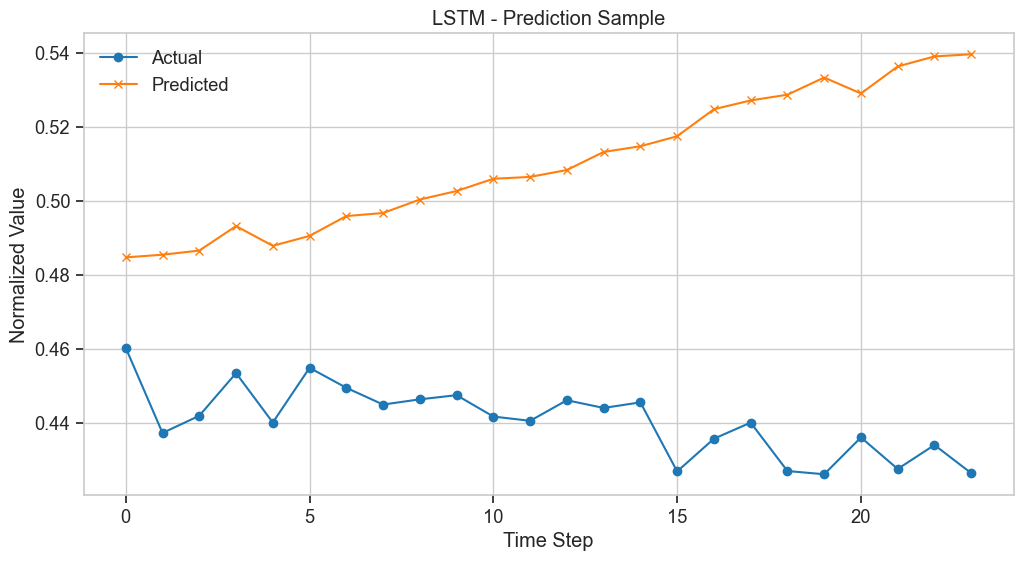

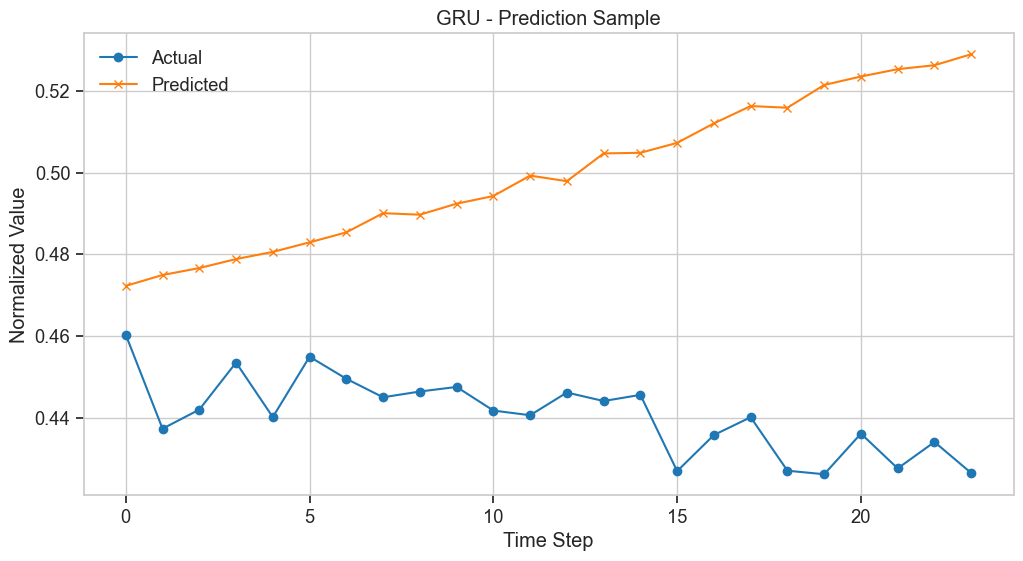

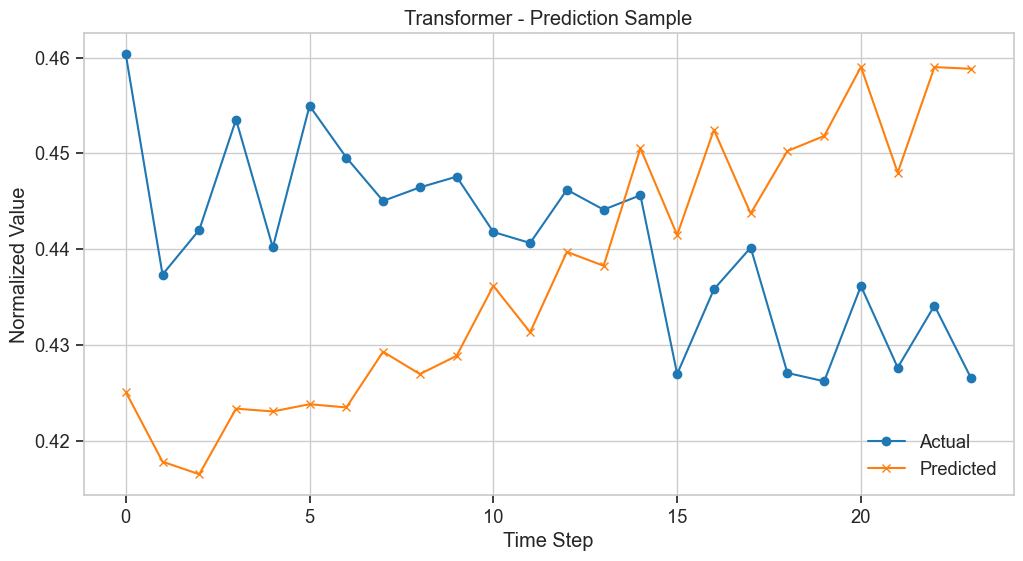

In [9]:

# Visualize predictions for a sample
def plot_prediction_sample(predictions, targets, model_name, sample_idx=0):
    pred = predictions[sample_idx].squeeze()
    targ = targets[sample_idx].squeeze()
    
    plt.figure(figsize=(12, 6))
    plt.plot(targ, label='Actual', marker='o')
    plt.plot(pred, label='Predicted', marker='x')
    plt.title(f'{model_name} - Prediction Sample')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()

sample_idx = 10  # Choose a sample to visualize
plot_prediction_sample(lstm_preds, lstm_targets, 'LSTM', sample_idx)
plt.savefig('lstm_prediction_sample.png', dpi=300)
plt.show()

plot_prediction_sample(gru_preds, gru_targets, 'GRU', sample_idx)
plt.savefig('gru_prediction_sample.png', dpi=300)
plt.show()

plot_prediction_sample(transformer_preds, transformer_targets, 'Transformer', sample_idx)
plt.savefig('transformer_prediction_sample.png', dpi=300)
plt.show()


### 8. Ensemble Model and Optimization

Best weights found: [0.  0.6 0.4] with MSE: 0.002007

Ensemble Test MSE: 0.001911


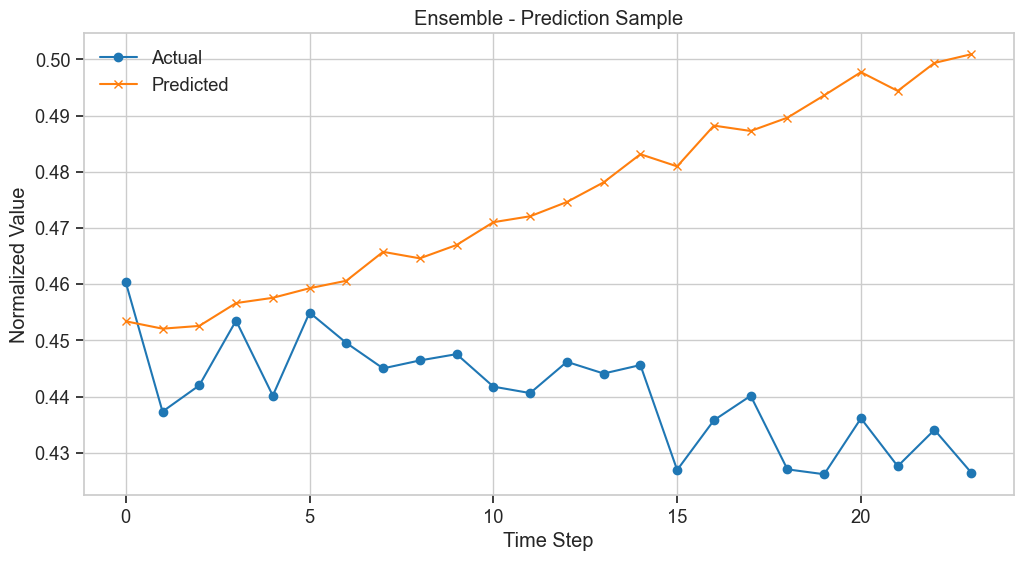

In [10]:

# Create ensemble prediction model
class EnsemblePredictionModel:
    def __init__(self, models, weights=None):
        self.models = models
        
        if weights is None:
            self.weights = np.ones(len(models)) / len(models)
        else:
            self.weights = np.array(weights) / np.sum(weights)
    
    def predict(self, x, device='cpu'):
        x_tensor = torch.FloatTensor(x).to(device)
        
        with torch.no_grad():
            predictions = []
            
            for i, model in enumerate(self.models):
                model.eval()
                pred = model(x_tensor).cpu().numpy()
                predictions.append(pred)
            
            # Weighted average of predictions
            ensemble_pred = np.zeros_like(predictions[0])
            
            for i, pred in enumerate(predictions):
                ensemble_pred += self.weights[i] * pred
            
            return ensemble_pred

# Optimize ensemble weights
def optimize_ensemble_weights(models, val_loader, device):
    # Get individual model predictions
    all_val_preds = []
    
    for model in models:
        model.eval()
        val_preds = []
        
        with torch.no_grad():
            for batch_x, _ in val_loader:
                batch_x = batch_x.to(device)
                outputs = model(batch_x).cpu().numpy()
                val_preds.append(outputs)
        
        val_preds = np.vstack(val_preds)
        all_val_preds.append(val_preds)
    
    # Get validation targets
    val_targets = []
    for _, batch_y in val_loader:
        val_targets.append(batch_y.numpy())
    val_targets = np.vstack(val_targets)
    
    # Grid search for optimal weights
    best_mse = float('inf')
    best_weights = np.ones(len(models)) / len(models)
    
    # Generate weight combinations
    weight_options = np.linspace(0, 1, 6)  # [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    if len(models) == 2:
        for w1 in weight_options:
            w2 = 1.0 - w1
            weights = np.array([w1, w2])
            
            # Calculate weighted prediction
            weighted_pred = np.zeros_like(all_val_preds[0])
            for i, pred in enumerate(all_val_preds):
                weighted_pred += weights[i] * pred
            
            # Calculate MSE
            mse = np.mean((weighted_pred - val_targets) ** 2)
            
            if mse < best_mse:
                best_mse = mse
                best_weights = weights
    
    elif len(models) == 3:
        from itertools import product
        
        for w1, w2 in product(weight_options, weight_options):
            w3 = 1.0 - w1 - w2
            if 0 <= w3 <= 1:
                weights = np.array([w1, w2, w3])
                
                # Calculate weighted prediction
                weighted_pred = np.zeros_like(all_val_preds[0])
                for i, pred in enumerate(all_val_preds):
                    weighted_pred += weights[i] * pred
                
                # Calculate MSE
                mse = np.mean((weighted_pred - val_targets) ** 2)
                
                if mse < best_mse:
                    best_mse = mse
                    best_weights = weights
    
    print(f"Best weights found: {best_weights} with MSE: {best_mse:.6f}")
    return best_weights

# Get optimal weights
best_weights = optimize_ensemble_weights([lstm_model, gru_model, transformer_model], val_loader, device)

# Create ensemble model
ensemble_prediction_model = EnsemblePredictionModel(
    models=[lstm_model, gru_model, transformer_model],
    weights=best_weights
)

# Evaluate ensemble model
def evaluate_ensemble_model(ensemble_model, data_loader, device):
    all_predictions = []
    all_targets = []
    
    for batch_x, batch_y in data_loader:
        batch_x_np = batch_x.numpy()
        batch_y_np = batch_y.numpy()
        
        outputs = ensemble_model.predict(batch_x_np, device)
        
        all_predictions.append(outputs)
        all_targets.append(batch_y_np)
    
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    
    mse = np.mean((all_predictions - all_targets) ** 2)
    
    return mse, all_predictions, all_targets

# Evaluate ensemble model
ensemble_loss, ensemble_preds, ensemble_targets = evaluate_ensemble_model(
    ensemble_prediction_model, test_loader, device
)

print(f"\nEnsemble Test MSE: {ensemble_loss:.6f}")

# Visualize ensemble prediction
plot_prediction_sample(ensemble_preds, ensemble_targets, 'Ensemble', sample_idx)
plt.savefig('ensemble_prediction_sample.png', dpi=300)
plt.show()


### 9. Model Comparison and Error Analysis


=== Model Comparison ===
Model        Test MSE    
-------------------------
LSTM         0.002909    
GRU          0.002851    
Transformer  0.001852    
Ensemble     0.001911    


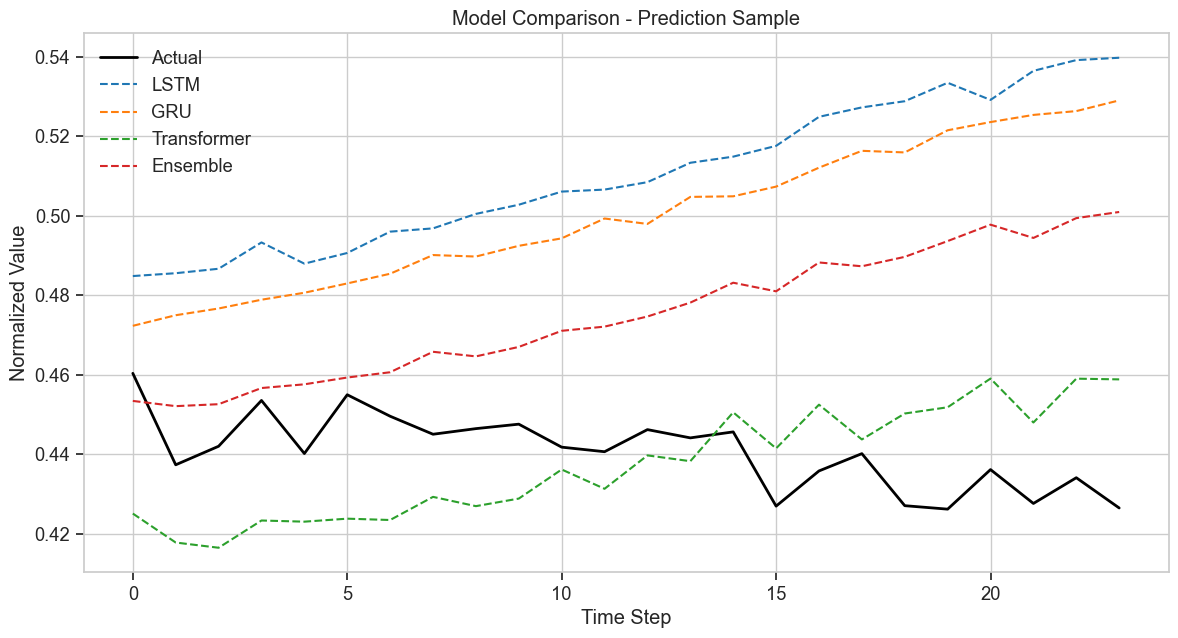

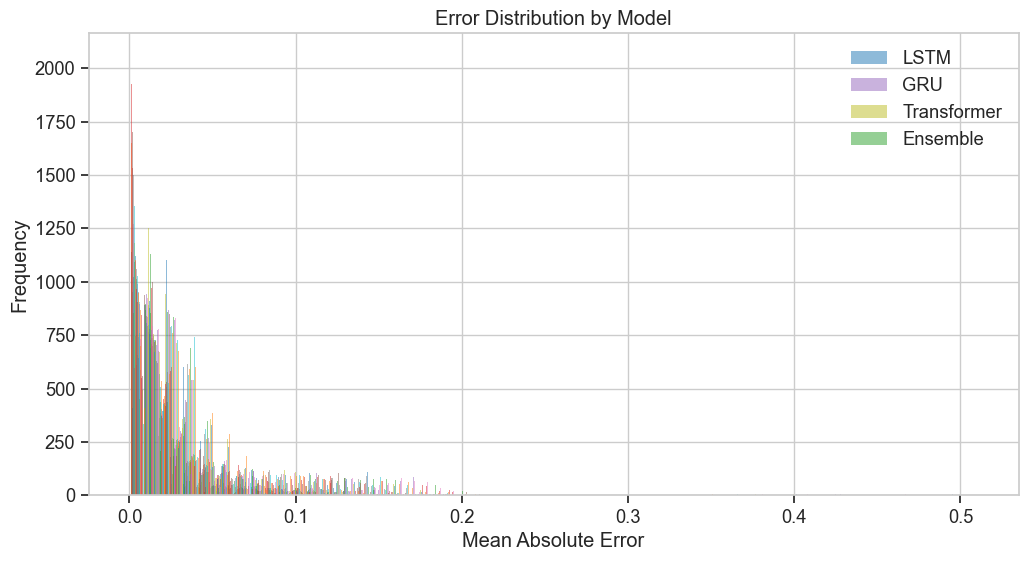

In [11]:

# Compare all models
print("\n=== Model Comparison ===")
print(f"{'Model':<12} {'Test MSE':<12}")
print("-" * 25)
print(f"{'LSTM':<12} {lstm_loss:<12.6f}")
print(f"{'GRU':<12} {gru_loss:<12.6f}")
print(f"{'Transformer':<12} {transformer_loss:<12.6f}")
print(f"{'Ensemble':<12} {ensemble_loss:<12.6f}")

# Plot comparison of all models for a sample
def plot_all_models_comparison(predictions_dict, targets, sample_idx=0):
    plt.figure(figsize=(14, 7))
    
    target = targets[sample_idx].squeeze()
    plt.plot(target, 'k-', lw=2, label='Actual')
    
    for model_name, preds in predictions_dict.items():
        pred = preds[sample_idx].squeeze()
        plt.plot(pred, '--', label=f'{model_name}')
    
    plt.title('Model Comparison - Prediction Sample')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()

# Compare all models on a sample
predictions_dict = {
    'LSTM': lstm_preds,
    'GRU': gru_preds,
    'Transformer': transformer_preds,
    'Ensemble': ensemble_preds
}

plot_all_models_comparison(predictions_dict, ensemble_targets, sample_idx)
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# Calculate prediction errors
def calculate_prediction_errors(predictions, targets):
    return np.mean(np.abs(predictions - targets), axis=2).squeeze()

lstm_errors = calculate_prediction_errors(lstm_preds, lstm_targets)
gru_errors = calculate_prediction_errors(gru_preds, gru_targets)
transformer_errors = calculate_prediction_errors(transformer_preds, transformer_targets)
ensemble_errors = calculate_prediction_errors(ensemble_preds, ensemble_targets)

# Plot error distribution
plt.figure(figsize=(12, 6))

plt.hist(lstm_errors, bins=50, alpha=0.5, label='LSTM')
plt.hist(gru_errors, bins=50, alpha=0.5, label='GRU')
plt.hist(transformer_errors, bins=50, alpha=0.5, label='Transformer')
plt.hist(ensemble_errors, bins=50, alpha=0.5, label='Ensemble')

plt.title('Error Distribution by Model')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.savefig('error_distribution.png', dpi=300)
plt.show()


### 10. Model Saving

In [12]:

# Save models
def save_prediction_models(models_dict, weights=None, base_path="models/prediction/"):
    import os
    import json
    
    os.makedirs(base_path, exist_ok=True)
    
    for name, model in models_dict.items():
        model_path = os.path.join(base_path, f"{name}_model.pt")
        torch.save(model.state_dict(), model_path)
        logger.info(f"Modelo {name} guardado en {model_path}")
    
    if weights is not None:
        # Save ensemble weights
        weights_dict = {
            "lstm": float(weights[0]),
            "gru": float(weights[1]),
            "transformer": float(weights[2])
        }
        
        with open(os.path.join(base_path, "ensemble_weights.json"), "w") as f:
            json.dump(weights_dict, f)
        
        logger.info(f"Ensemble weights saved to {os.path.join(base_path, 'ensemble_weights.json')}")
    
    # Save configuration
    config = {
        "sequence_length": sequence_length,
        "prediction_horizon": prediction_horizon,
        "embedding_dim": 64,
        "input_size": 1
    }
    
    with open(os.path.join(base_path, "model_config.json"), "w") as f:
        json.dump(config, f)
    
    logger.info(f"Configuration saved to {os.path.join(base_path, 'model_config.json')}")

# Save prediction models
save_prediction_models(
    models_dict={
        "lstm": lstm_model,
        "gru": gru_model,
        "transformer": transformer_model
    },
    weights=best_weights,
    base_path="models/prediction/"
)


2025-05-23 22:24:18,465 - INFO - Modelo lstm guardado en models/prediction/lstm_model.pt
2025-05-23 22:24:18,467 - INFO - Modelo gru guardado en models/prediction/gru_model.pt
2025-05-23 22:24:18,469 - INFO - Modelo transformer guardado en models/prediction/transformer_model.pt
2025-05-23 22:24:18,470 - INFO - Ensemble weights saved to models/prediction/ensemble_weights.json
2025-05-23 22:24:18,471 - INFO - Configuration saved to models/prediction/model_config.json


### 11. Model Loading and Prediction

In [13]:

def load_prediction_models(base_path="models/prediction/"):
    import os
    import json
    
    # Load configuration
    with open(os.path.join(base_path, "model_config.json"), "r") as f:
        config = json.load(f)
    
    sequence_length = config["sequence_length"]
    prediction_horizon = config["prediction_horizon"]
    embedding_dim = config["embedding_dim"]
    input_size = config["input_size"]
    
    # Initialize models
    lstm_model = LSTMMultiStepPredictor(
        input_size=input_size,
        hidden_size=embedding_dim,
        num_layers=2,
        output_size=prediction_horizon,
        dropout=0.2
    )
    
    gru_model = GRUMultiStepPredictor(
        input_size=input_size,
        hidden_size=embedding_dim,
        num_layers=2,
        output_size=prediction_horizon,
        dropout=0.2
    )
    
    transformer_model = TransformerPredictor(
        input_size=input_size,
        d_model=embedding_dim,
        nhead=4,
        dim_feedforward=128,
        num_layers=2,
        output_size=prediction_horizon,
        dropout=0.2
    )
    
    # Load model weights
    lstm_model.load_state_dict(torch.load(os.path.join(base_path, "lstm_model.pt")))
    gru_model.load_state_dict(torch.load(os.path.join(base_path, "gru_model.pt")))
    transformer_model.load_state_dict(torch.load(os.path.join(base_path, "transformer_model.pt")))
    
    # Load ensemble weights
    with open(os.path.join(base_path, "ensemble_weights.json"), "r") as f:
        weights_dict = json.load(f)
    
    weights = [weights_dict["lstm"], weights_dict["gru"], weights_dict["transformer"]]
    
    # Create ensemble model
    ensemble_model = EnsemblePredictionModel(
        models=[lstm_model, gru_model, transformer_model],
        weights=weights
    )
    
    logger.info(f"Prediction models loaded from {base_path}")
    
    return {
        "lstm": lstm_model,
        "gru": gru_model,
        "transformer": transformer_model,
        "ensemble": ensemble_model,
        "config": config
    }

# Function to make predictions with the saved models
def make_predictions(new_data, models, scaler=None, device='cpu'):
    # Preprocess data
    if scaler is not None and not isinstance(new_data, np.ndarray):
        new_data = scaler.transform(new_data.values.reshape(-1, 1))
    
    # Create sequences
    config = models["config"]
    sequence_length = config["sequence_length"]
    
    # Create sequence from most recent data
    if len(new_data) >= sequence_length:
        recent_data = new_data[-sequence_length:].reshape(1, sequence_length, 1)
    else:
        # If not enough data, pad with zeros
        pad_size = sequence_length - len(new_data)
        padding = np.zeros((pad_size, 1))
        recent_data = np.concatenate([padding, new_data]).reshape(1, sequence_length, 1)
    
    # Make predictions
    ensemble_model = models["ensemble"]
    predictions = ensemble_model.predict(recent_data, device)
    
    # Inverse transform if scaler provided
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.squeeze()).reshape(-1, 1)
    
    return predictions